In [1]:
import json
import os
import os.path as osp
import sys

import torch
from mmcv import Config
import time
from dataset import build_data_loader
from models import build_model
from models.utils import fuse_module
from utils import AverageMeter, Corrector, ResultFormat
import numpy as np

/opt/conda/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [2]:
cfg = Config.fromfile('config/pan_pp/pan_pp_test.py')

cfg.debug = False
cfg.report_speed = False

cfg

Config (path: config/pan_pp/pan_pp_test.py): {'model': {'type': 'PAN_PP', 'backbone': {'type': 'resnet50', 'pretrained': True}, 'neck': {'type': 'FPEM_v2', 'in_channels': (256, 512, 1024, 2048), 'out_channels': 128}, 'detection_head': {'type': 'PAN_PP_DetHead', 'in_channels': 512, 'hidden_dim': 128, 'num_classes': 6, 'loss_text': {'type': 'DiceLoss', 'loss_weight': 1.0}, 'loss_kernel': {'type': 'DiceLoss', 'loss_weight': 0.5}, 'loss_emb': {'type': 'EmbLoss_v2', 'feature_dim': 4, 'loss_weight': 0.25}, 'use_coordconv': False}}, 'data': {'batch_size': 1, 'train': {'type': 'PAN_PP_TEST', 'split': 'train', 'is_transform': True, 'img_size': 736, 'short_size': 736, 'kernel_scale': 0.5, 'read_type': 'pil', 'with_rec': False}, 'test': {'type': 'PAN_PP_TEST', 'split': 'test', 'short_size': 1024, 'read_type': 'cv2', 'with_rec': False}}, 'train_cfg': {'lr': 0.001, 'schedule': 'polylr', 'epoch': 200, 'optimizer': 'Adam', 'use_ex': False}, 'test_cfg': {'min_score': 0.75, 'min_area': 260, 'min_kernel

In [3]:
data_loader = build_data_loader(cfg.data.test)
test_loader = torch.utils.data.DataLoader(
    data_loader,
    batch_size=1,
    shuffle=False,
    num_workers=2,
)
model = build_model(cfg.model)
model = model.cuda()

reading type: cv2.


In [4]:
len(test_loader)

101

In [5]:
checkpoint_path = 'weights/doc_panpp_best_weight.pth.tar'
if checkpoint_path is not None:
    if os.path.isfile(checkpoint_path):
        print("Loading model and optimizer from checkpoint '{}'".format(
            checkpoint_path))
        sys.stdout.flush()

        checkpoint = torch.load(checkpoint_path)

        d = dict()
        for key, value in checkpoint['state_dict'].items():
            tmp = key[7:]
#             print(tmp)
            d[tmp] = value
        model.load_state_dict(d)
    else:
        print("No checkpoint found")
        raise

Loading model and optimizer from checkpoint 'weights/doc_panpp_best_weight.pth.tar'


In [6]:
model = fuse_module(model)

In [7]:
model.eval()
rf = ResultFormat(cfg.data.test.type, cfg.test_cfg.result_path)

In [8]:
rf.result_path

'outputs/2023-02-10-15:47:37910102'

In [9]:
starttime = time.time()
for idx, data in enumerate(test_loader):
    if idx == 1:
        break
    print('Testing %d/%d\r' % (idx, len(test_loader)), flush=True, end='')

    # prepare input
    data['imgs'] = data['imgs'].cuda()
    data.update(dict(cfg=cfg))

    # forward
    with torch.no_grad():
        outputs = model(**data)

    if cfg.report_speed:
        report_speed(outputs, speed_meters)

    # save result
    image_name, _ = osp.splitext(osp.basename(test_loader.dataset.img_paths[idx]))
    image_path = test_loader.dataset.img_paths[idx]
    rf.write_result(image_name,image_path, outputs)

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [10]:
data['imgs'] = data['imgs'].cuda()
data.update(dict(cfg=cfg))
data

{'imgs': tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
           [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
           [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
           ...,
           [2.2318, 2.2318, 2.2318,  ..., 2.2489, 2.2489, 2.2489],
           [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
           [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],
 
          [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
           [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
           [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
           ...,
           [2.4111, 2.4111, 2.4111,  ..., 2.4286, 2.4286, 2.4286],
           [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
           [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],
 
          [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
           [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
           [2.64

In [11]:
out_det = torch.zeros(1, 6, 368, 256) # torch.zeros(1, 6, 256, 336)
def copy_data(m, i, o):
    print(o.data.shape)
    out_det.copy_(o.data)

In [12]:
h = model.det_head.register_forward_hook(copy_data)
with torch.no_grad():
    model(**data)

torch.Size([1, 6, 368, 256])


In [13]:
h.remove()

In [14]:
from matplotlib import pyplot as plt

# fig = plt.figure(figsize=(15, 15))
# plt.imshow(data['imgs'].cpu()[0,:,:,:].permute(1,2,0)) # HANWHA_HWT_7
# plt.axis('off');
# data['imgs'].shape # torch.Size([1, 3, 1024, 1344])

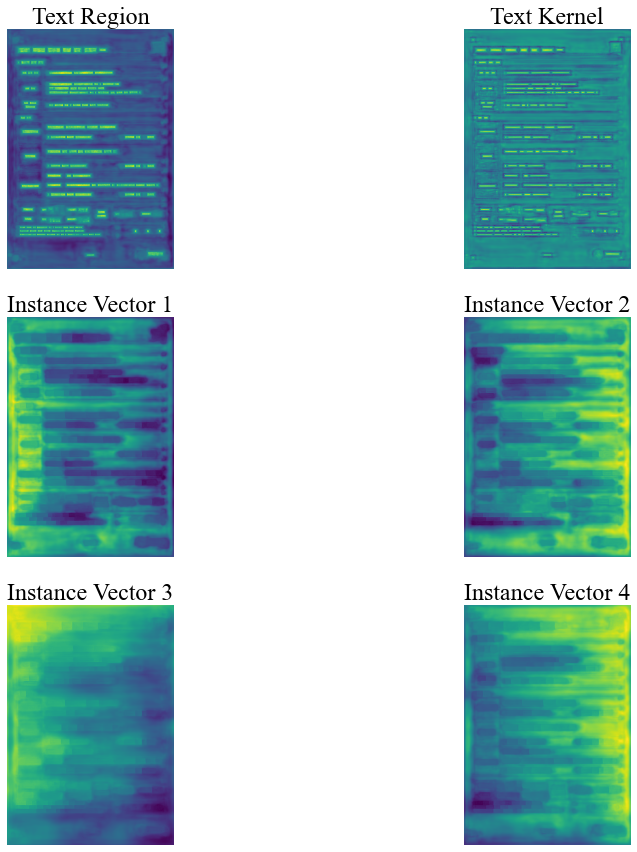

In [15]:
fig = plt.figure(figsize=(15, 15))
tit = ['Text Region', 'Text Kernel', 'Instance Vector 1', 'Instance Vector 2', 'Instance Vector 3', 'Instance Vector 4']
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20

for i in range(6):
    plt.subplot(3, 2, i + 1)
    img = out_det[0,i,:,:]
    plt.imshow(img)
    plt.title(tit[i])
    plt.axis('off')
plt.show()
# plt.savefig('test.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

# out_det.shape # torch.Size([1, 6, 256, 336])

In [16]:
out_det_2 = model._upsample(out_det, data['imgs'].size(), cfg.test_cfg.scale) # torch.Size([1, 6, 512, 672])

img_metas = data['img_metas']
res_det = model.det_head.get_results(out_det_2, img_metas, cfg) # PA

# data['imgs'].size() # torch.Size([1, 3, 1024, 1344])
# out_det.shape # torch.Size([1, 6, 256, 336])
# cfg.test_cfg.scale # 2
# data['img_metas'] {'org_img_size': tensor([[7290, 9348]]), 'img_size': tensor([[1024, 1344]])}

In [17]:
def draw_bboxes(arr, img_metas):
    const_x = img_metas['org_img_size'][0][1] / img_metas['img_size'][0][1]
    const_y = img_metas['org_img_size'][0][0] / img_metas['img_size'][0][0]
    plt.plot([arr[0] / const_x, arr[2] / const_x], [arr[1] / const_y, arr[3] / const_y], color=[1, 0, 0])
    plt.plot([arr[2] / const_x, arr[4] / const_x], [arr[3] / const_y, arr[5] / const_y], color=[1, 0, 0])
    plt.plot([arr[4] / const_x, arr[6] / const_x], [arr[5] / const_y, arr[7] / const_y], color=[1, 0, 0])
    plt.plot([arr[6] / const_x, arr[0] / const_x], [arr[7] / const_y, arr[1] / const_y], color=[1, 0, 0])

In [18]:
fig = plt.figure(figsize=(15, 15))
tit = ['Text Region', 'Text Kernel', 'Instance Vector 1', 'Instance Vector 2', 'Instance Vector 3', 'Instance Vector 4']
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20

# fig = plt.figure(figsize=(15, 15))
# plt.imshow(data['imgs'].cpu()[0,:,:,:].permute(1,2,0))
# plt.axis('off');
# for bbox in res_det['bboxes']:        
#     draw_bboxes(bbox, img_metas)
# plt.show()
# plt.savefig('test.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

<Figure size 1080x1080 with 0 Axes>

In [19]:
res_det.keys()

dict_keys(['scale_org', 'label_org', 'score_org', 'scale', 'label', 'label_num', 'score', 'bboxes', 'scores', 'kernels', 'emb', 'img_size'])

In [20]:
print(res_det['scale_org'].shape)
print(res_det['label_org'].shape)
print(res_det['score_org'].shape)
print(res_det['scale'].shape)
print(res_det['label'].shape)
print(res_det['label_num'])
print(res_det['score'].shape)

scale_org = res_det['scale_org']
label_org = res_det['label_org']
score_org = res_det['score_org']
scale = res_det['scale']
label = res_det['label']
label_num = res_det['label_num']
score = res_det['score']

(2,)
(736, 512)
(736, 512)
(2,)
(368, 256)
151
(368, 256)


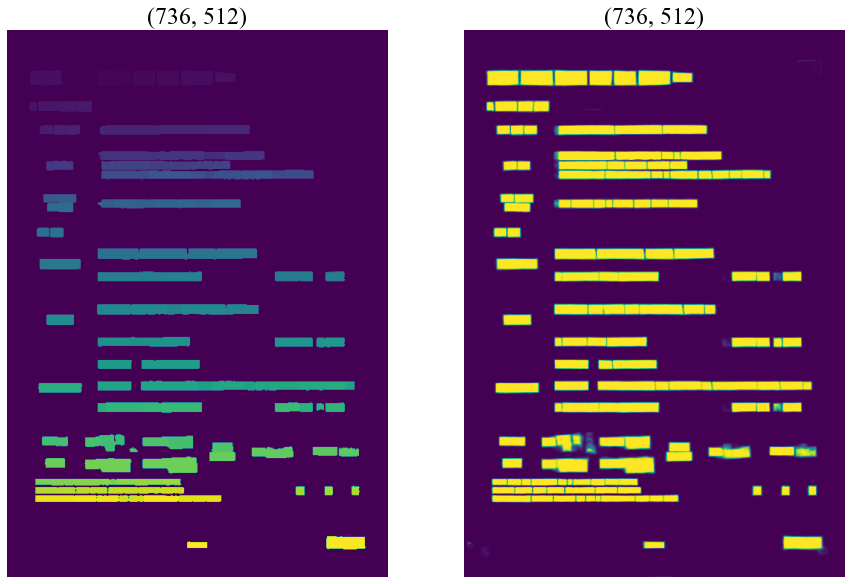

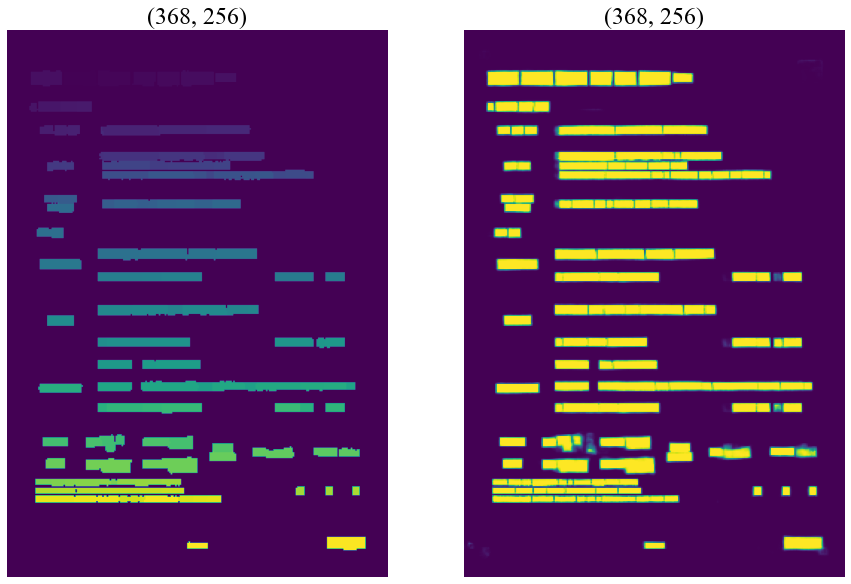

(736, 512) (368, 256)


In [21]:
img1 = [label_org, score_org]
img2 = [label, score]

for i in [img1, img2]:
    fig = plt.figure(figsize=(15, 15))
    for k, j in enumerate(i):
        plt.subplot(1, 2, k + 1)
        plt.imshow(j)
        plt.title(str(j.shape))
        plt.axis('off')
    plt.show()
    
print(label_org.shape, label.shape)

In [22]:
import cv2

def draw_bboxes(arr, scale):
    const_x = scale[0]
    const_y = scale[1]
    plt.plot([arr[0] / const_x, arr[2] / const_x], [arr[1] / const_y, arr[3] / const_y], color=[1, 0, 0])
    plt.plot([arr[2] / const_x, arr[4] / const_x], [arr[3] / const_y, arr[5] / const_y], color=[1, 0, 0])
    plt.plot([arr[4] / const_x, arr[6] / const_x], [arr[5] / const_y, arr[7] / const_y], color=[1, 0, 0])
    plt.plot([arr[6] / const_x, arr[0] / const_x], [arr[7] / const_y, arr[1] / const_y], color=[1, 0, 0])
    
def post_processing(label, score, resize_const):
    org_img_size = data['img_metas']['org_img_size'][0]
    img_size = data['img_metas']['img_size'][0]
    scale_org = np.array((float(org_img_size[1]) / float(img_size[1]), float(org_img_size[0]) / float(img_size[0])))
    scale = scale_org*resize_const
    label = cv2.resize(label, (int(img_size[1]//resize_const), int(img_size[0]//resize_const)),
                       interpolation=cv2.INTER_NEAREST)
    score = cv2.resize(score, (int(img_size[1]//resize_const), int(img_size[0]//resize_const)),
                       interpolation=cv2.INTER_NEAREST)
    bboxes = []
    scores = []
    for i in range(1, label_num):
        ind = label == i
        points = np.array(np.where(ind)).transpose((1, 0))

        score_i = np.mean(score[ind])
        if score_i < cfg.test_cfg.min_score:
            label[ind] = 0
            continue

        if cfg.test_cfg.bbox_type == 'rect':
            pos, length, deg = cv2.minAreaRect(points[:, ::-1])
            pos, length = np.array(pos), np.array(length)
            pos, length = pos*scale, length*scale
            bbox = cv2.boxPoints((pos, length, deg))

        bbox = bbox.astype('int32')
        bboxes.append(bbox.reshape(-1))
        scores.append(score_i)
    #############################################
    fig = plt.figure(figsize=(15, 15))
    for i, j in enumerate([label, score]):
        plt.subplot(1,2,i+1)
        plt.imshow(label)
        for i in bboxes:
            draw_bboxes(i, scale)
        plt.title(str(j.shape))
        plt.axis('off')
#     fig = plt.figure(figsize=(15, 15))
#     plt.imshow(data['imgs'].cpu()[0,:,:,:].permute(1,2,0))
#     for i in bboxes:
#         draw_bboxes(i, scale_org)
#     plt.title(str(data['imgs'].cpu()[0,:,:,:].permute(1,2,0).shape))
#     plt.axis('off')
    return bboxes

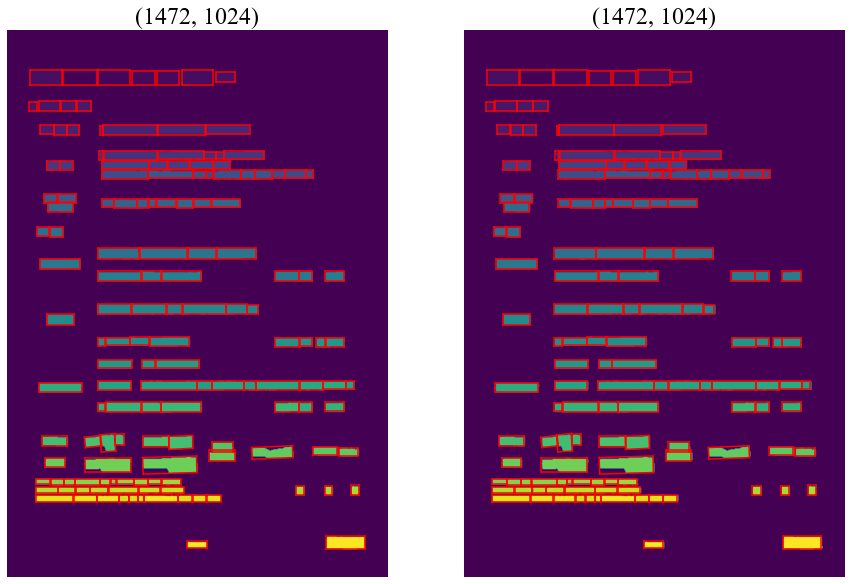

In [23]:
resize_1 = post_processing(label_org, score_org, 1)

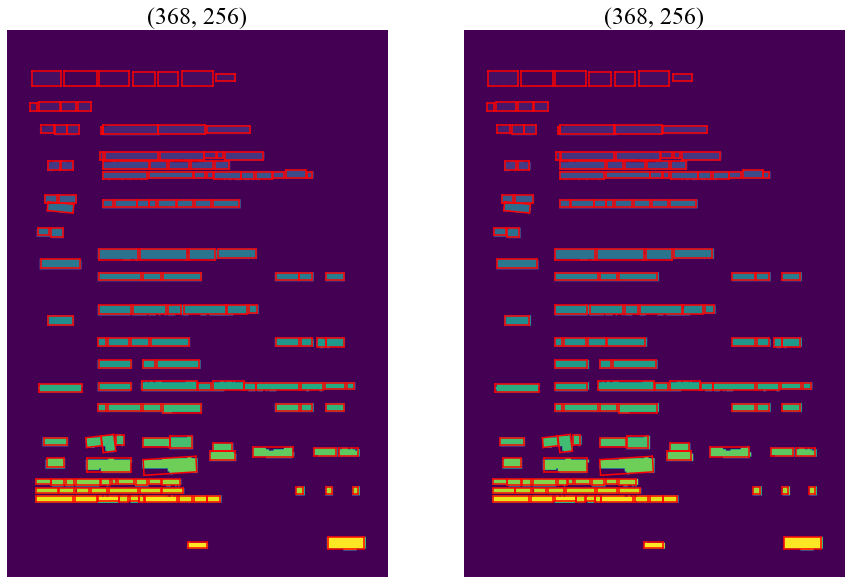

In [24]:
resize_16 = post_processing(label_org, score_org, 4)

In [25]:
print(resize_1[0])
print(resize_16[0])

[182 128 291 128 291 177 182 177]
[184 176 184 128 290 128 290 176]


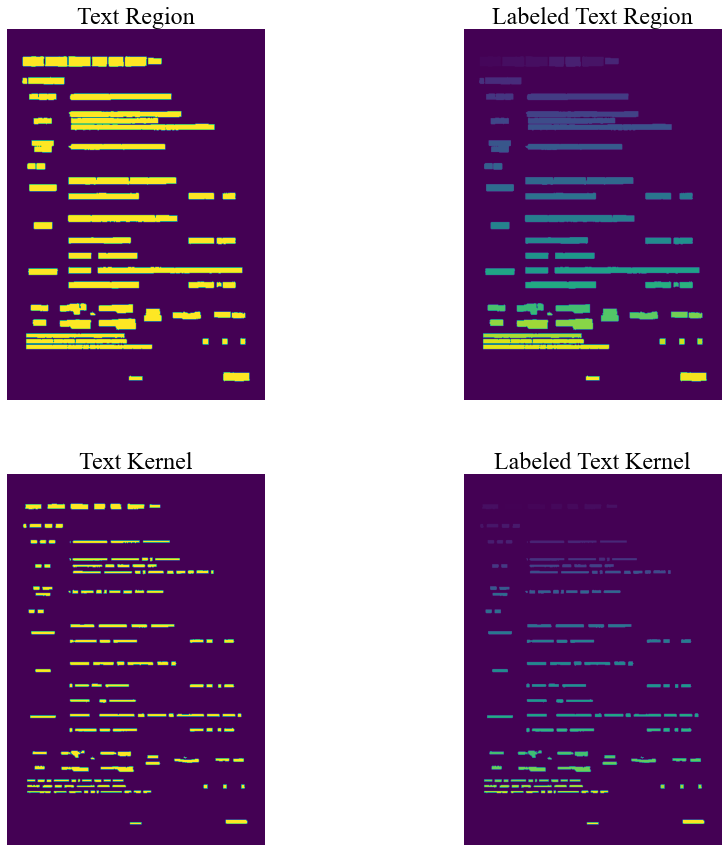

56 150


In [26]:
kernels = res_det['kernels']
_, cc = cv2.connectedComponents(kernels[0], connectivity=4)
label_num, label_k = cv2.connectedComponents(kernels[1], connectivity=4)

img = [kernels[0], cc, kernels[1], label_k]
tit = ["Text Region", "Labeled Text Region", "Text Kernel", "Labeled Text Kernel"]
fig = plt.figure(figsize=(15, 15))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(img[i])
    plt.title(tit[i])
    plt.axis('off')
plt.show()
print(cc.max(), label.max())

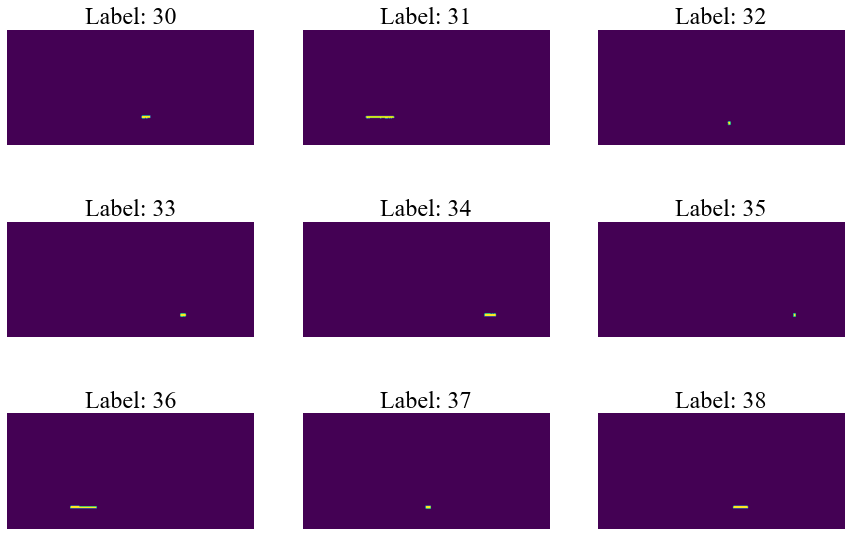

In [27]:
fig = plt.figure(figsize=(15, 10))

for i in range(30, 39): # (1, label_num):
    ind = label_k == i
    plt.subplot(3, 3, i - 29)
    plt.imshow(ind[:240, :])
    plt.title('Label: ' + str(i))
    plt.axis('off')
plt.show()
# plt.savefig('test.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

In [28]:
# import cv2
# from models.post_processing import connectedComponents

# fig = plt.figure(figsize=(15, 15))

# plt.subplot(1,2,1)
# kernels = res_det['kernels']
# _, cc = cv2.connectedComponents(kernels[0], connectivity=4)
# label_num, label = cv2.connectedComponents(kernels[1], connectivity=4)
# print(cc.shape, label_num, label.shape, label.max())
# plt.imshow(label)
# plt.axis('off')

# plt.subplot(1,2,2)
# res = connectedComponents(kernels[1].astype(np.int32))
# label_conn, area, inds, label_num, px, py = res
# print(label_num, label.shape, label.max())
# plt.imshow(label)
# plt.axis('off')
# plt.show()

In [29]:
# X = np.where(kernels[1] == 1)
# Y = np.where(kernels[1] == 0)
# print(len(X[0]), len(Y[0]))
# print(len(X[0]) + len(Y[0]), kernels[1].shape[0] * kernels[1].shape[1])